In [2]:
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd() ,"..")))


In [3]:
# Import libraries
import src.data.sql_functions as sql
import src.data.data_transformation as cln
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings     
import pandas_ta as pta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import joblib

In [4]:
# Global variables
warnings.filterwarnings("ignore")
DB_SERVER   = "tcp:AUCLD04018656,1433"
DB_NAME     = "team_five_aiml_group"
LIST_CONVERT_FLOAT = [
'bitcoin_transaction'                       
,'size_btc'                                  
,'sentbyaddress_btc'                         
,'bitcoin_difficulty'                        
,'bitcoin_hashrate'                          
,'bitcoin_mining_profitability'              
,'sentinusd_btc'                             
,'bitcoin_transactionfees'                   
,'bitcoin_median_transaction_fee'            
,'bitcoin_confirmationtime'                  
,'transactionvalue_btc'                      
,'mediantransactionvalue_btc'                
,'tweets_btc'                                
,'google_trends_btc'                         
,'activeaddresses_btc'                       
,'top100cap_btc'                             
,'fee_to_reward_btc'] 
SMOOTHING_RANGE = 5
MODEL_PARAMETERS = {
    "test_size": 0.25,
    "random_state": 15,
}

In [5]:
# Get market/supp data from database
conn = sql.SqlDb(DB_SERVER, DB_NAME)
get_query = "SELECT * FROM [{db}].[dbo].BTC_AUD_{dt} A LEFT JOIN [{db}].[dbo].BTC_SUPP_DATA_{dt} B ON A.mkt_Date = B.supp_date".format(db=DB_NAME, dt="20130101_20230127")
df_btc_input = conn.query(get_query, True)
conn.__del__


<bound method SqlDb.__del__ of <src.data.sql_functions.SqlDb object at 0x000002E497081DF0>>

In [6]:
df_btc_input

,mkt_Date,mkt_Open,mkt_High,mkt_Low,mkt_Close,mkt_Adj_Close,mkt_Volume,supp_date,bitcoin_transaction,size_btc,...,bitcoin_transactionfees,bitcoin_median_transaction_fee,bitcoin_confirmationtime,transactionvalue_btc,mediantransactionvalue_btc,tweets_btc,google_trends_btc,activeaddresses_btc,top100cap_btc,fee_to_reward_btc
0,2014-09-17,513.122620,516.007935,504.935272,510.645386,510.645386,23511389,2014-09-17,80119,240563,...,0.0699,0.0456,7.742,2636,110.753,27946,7.619,170439,19.806,0.264
1,2014-09-18,510.116119,510.002228,459.924286,472.650330,472.650330,38400000,2014-09-18,77185,236621,...,0.0701,0.0439,8.045,3951,131.235,21135,7.619,171901,19.848,0.276
2,2014-09-19,472.275055,477.761017,428.161682,442.249359,442.249359,42477540,2014-09-19,69266,221271,...,0.0622,0.0406,8.421,4006,130.667,20775,9.675,150729,19.822,0.248
3,2014-09-20,442.111572,474.174957,436.745819,458.053101,458.053101,41294500,2014-09-20,63306,208320,...,0.0665,0.041,8.182,4860,94.343,17607,7.377,149520,19.925,0.233
4,2014-09-21,457.135651,461.998413,440.440247,446.308197,446.308197,29744964,2014-09-21,59636,217914,...,0.0628,0.0401,8.78,5157,80.706,17026,7.498,171703,19.952,0.228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049,2023-01-22,32718.300781,33118.687500,32132.189453,32532.294922,32532.294922,35433187363,2023-01-22,250609,579095,...,1.252,0.46,9.536,59073,320.652,109526,None,731799,14.766,1.438
3050,2023-01-23,32533.259766,32880.914062,32454.919922,32628.861328,32628.861328,37728208256,2023-01-23,293551,595639,...,1.161,0.493,9.114,65939,362.406,160357,None,808878,14.774,1.49
3051,2023-01-24,32622.027344,32852.843750,32049.951172,32103.673828,32103.673828,37448409211,2023-01-24,292841,699082,...,1.328,0.558,11.163,59474,378.55,106272,None,751671,14.743,2.058
3052,2023-01-25,32107.642578,33391.179688,31629.132812,32532.884766,32532.884766,43182350526,2023-01-25,306506,531720,...,0.959,0.35,8.229,62699,378.707,111179,None,785862,14.746,1.171


In [7]:
# Create next day closing price variable, and new features 
df_btc_input['t_plus_1_Close'] = df_btc_input['mkt_Close'].shift(-1)
df_btc_input['t_plus_1_Return'] = df_btc_input['mkt_Close'].pct_change(1)
df_btc_input['t_range'] = df_btc_input['mkt_High'] - df_btc_input['mkt_Low'] 
df_btc_input['t_closing_var'] = pta.variance(df_btc_input['mkt_Close'], SMOOTHING_RANGE)
df_btc_input['t_closing_rsi'] = pta.rsi(df_btc_input['mkt_Close'], SMOOTHING_RANGE)
df_btc_input['t_closing_roc'] = pta.roc(df_btc_input['mkt_Close'],SMOOTHING_RANGE)

for c in LIST_CONVERT_FLOAT:
     df_btc_input[c] = df_btc_input[c].astype(float) 
clean_df_btc_input = cln.clean_df(df_btc_input)
clean_df_btc_input.head(15)

,mkt_Date,mkt_Open,mkt_High,mkt_Low,mkt_Close,mkt_Adj_Close,mkt_Volume,supp_date,bitcoin_transaction,size_btc,...,google_trends_btc,activeaddresses_btc,top100cap_btc,fee_to_reward_btc,t_plus_1_Close,t_plus_1_Return,t_range,t_closing_var,t_closing_rsi,t_closing_roc
0,2014-09-17,513.122620,516.007935,504.935272,510.645386,510.645386,23511389,2014-09-17,80119.0,240563.0,...,7.619,170439.0,19.806,0.264,472.650330,NaN,11.072662,NaN,NaN,NaN
1,2014-09-18,510.116119,510.002228,459.924286,472.650330,472.650330,38400000,2014-09-18,77185.0,236621.0,...,7.619,171901.0,19.848,0.276,442.249359,-0.074406,50.077942,NaN,NaN,NaN
2,2014-09-19,472.275055,477.761017,428.161682,442.249359,442.249359,42477540,2014-09-19,69266.0,221271.0,...,9.675,150729.0,19.822,0.248,458.053101,-0.064320,49.599335,NaN,NaN,NaN
3,2014-09-20,442.111572,474.174957,436.745819,458.053101,458.053101,41294500,2014-09-20,63306.0,208320.0,...,7.377,149520.0,19.925,0.233,446.308197,0.035735,37.429138,NaN,NaN,NaN
4,2014-09-21,457.135651,461.998413,440.440247,446.308197,446.308197,29744964,2014-09-21,59636.0,217914.0,...,7.498,171703.0,19.952,0.228,453.077972,-0.025641,21.558167,763.112214,NaN,NaN
5,2014-09-22,446.620422,456.952271,444.913727,453.077972,453.077972,27182965,2014-09-22,72900.0,261061.0,...,7.982,178105.0,19.952,0.279,492.530487,0.015168,12.038544,140.314950,29.410747,-11.273462
6,2014-09-23,453.010376,499.442383,444.316467,492.530487,492.530487,50971406,2014-09-23,77133.0,309494.0,...,8.707,173452.0,19.872,0.339,477.765839,0.087077,55.125916,400.094940,62.029096,4.206103
7,2014-09-24,492.485321,492.392456,474.621887,477.765839,477.765839,34576315,2014-09-24,74818.0,285427.0,...,10.159,163682.0,19.886,0.316,467.538330,-0.029977,17.770569,364.793827,51.003923,8.030872
8,2014-09-25,477.710541,477.905640,466.045959,467.538330,467.538330,30460525,2014-09-25,78351.0,283495.0,...,8.466,177845.0,19.893,0.307,461.514313,-0.021407,11.859680,347.246500,44.201228,2.070771
9,2014-09-26,467.373596,471.199158,455.279999,461.514313,461.514313,24490243,2014-09-26,72421.0,310033.0,...,7.982,157374.0,19.906,1.411,455.916901,-0.012885,15.919159,232.793703,40.248859,3.407089


In [8]:
# Feature scaling
select_features = ['mkt_Close','mkt_Volume', 'bitcoin_transaction', 'bitcoin_difficulty', 'sentinusd_btc',
       'bitcoin_transactionfees', 'bitcoin_confirmationtime', 'transactionvalue_btc',
       'mediantransactionvalue_btc', 'tweets_btc', 'google_trends_btc',
       'activeaddresses_btc', 'top100cap_btc', 'fee_to_reward_btc', 't_range', 't_closing_var',
       't_closing_rsi', 't_closing_roc']

scaler = RobustScaler()
clean_df_btc_input[select_features] = scaler.fit_transform(clean_df_btc_input[select_features])

select_features.extend(['t_plus_1_Return'])
clean_df_btc_input.drop(clean_df_btc_input.columns.difference(select_features), axis=1, inplace=True)

In [9]:
clean_df_btc_input.dropna(inplace=True)
dfx = clean_df_btc_input[clean_df_btc_input.columns.difference(['t_plus_1_Return'])]
dfy = clean_df_btc_input['t_plus_1_Return']
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=MODEL_PARAMETERS["test_size"], random_state=MODEL_PARAMETERS["random_state"])

0.023371496410582036
0.0011856260492617951
0.25700493656009504


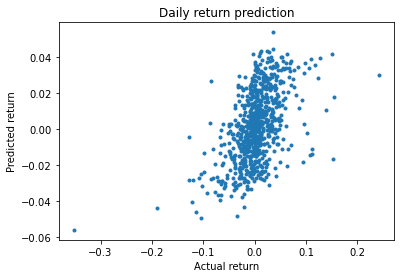

In [10]:
# Fitting the multiple linear regression model with the training data
pipeline = make_pipeline(scaler,LinearRegression())
model = pipeline.fit(X_train,y_train)

# Making predictions using the testing data
predict_y = model.predict(X_test)
print(mean_absolute_error(y_test, predict_y))
print(mean_squared_error(y_test, predict_y))
print(model.score(X_test,y_test))

# Plotting the predicted values against the actual values
plt.plot(y_test,predict_y, ".")
plt.ylabel('Predicted return')
plt.xlabel('Actual return')
plt.title("Daily return prediction")
plt.show()


# The best way to do this is to create an ML pipeline like the following:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

pipeline = make_pipeline(MinMaxScaler(),YOUR_ML_MODEL() )
model = pipeline.fit(X_train, y_train)

# Now you can save it to a file:
joblib.dump(model, 'filename.mod') 

# Later you can load it like this:
model = joblib.load('filename.mod')

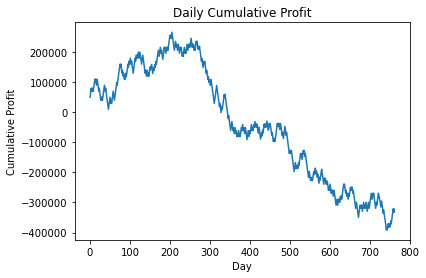

In [39]:
# Trading decision and profit/loss calculation with threshold
STOP_LOSS_PROFIT_THRESHOLD = 10000
INITIAL_CAPITAL = 50000
profit_loss = []
for i in range(len(y_test)):
    predicted_return = predict_y[i]
    actual_return = y_test.iloc[i]
    t_closing_price = X_test.iloc[i]['mkt_Close']
    if predicted_return < t_closing_price:
        
        trading_decision = 'Sell'
        A = (t_closing_price - max(actual_return, predicted_return)) * (INITIAL_CAPITAL / t_closing_price)
        B = STOP_LOSS_PROFIT_THRESHOLD
        profit_loss.append(min(abs(A), abs(B)) * (A / abs(A)))
    elif predicted_return > t_closing_price:
        trading_decision = 'Buy'
        A = (min(actual_return, predicted_return) - t_closing_price) * (INITIAL_CAPITAL / t_closing_price)
        B = STOP_LOSS_PROFIT_THRESHOLD
        profit_loss.append(min(abs(A), abs(B)) * (A / abs(A)))
    else:
        trading_decision = 'Hold'
        profit_loss.append(0)

# Calculate daily cumulative profit
cumulative_profit = [INITIAL_CAPITAL]
for i in range(1, len(profit_loss)):
    cumulative_profit.append(cumulative_profit[i-1] + profit_loss[i])

plt.plot(range(len(y_test)), cumulative_profit)
plt.ylabel('Cumulative Profit')
plt.xlabel('Day')
plt.title("Daily Cumulative Profit")
plt.show()

In [13]:
# SGDRegressor - test only
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                       tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
sgd_reg.fit(X_train,y_train)

ytest_pred = sgd_reg.predict(X_test)
print(sgd_reg.coef_)
print(mean_absolute_error(y_test, ytest_pred))
print(mean_squared_error(y_test, ytest_pred))


[ 7.57356234e-03  2.64028126e-03 -2.87208731e-02 -1.10740029e-02
  1.15644594e-03 -5.90735428e-03 -8.24056812e-04  2.74769246e-04
 -3.47241730e-03  9.77235165e-04  1.27073327e-03  3.46173897e-03
  2.70587402e-02  9.42055870e-05 -1.95261512e-03 -3.04117279e-02
 -1.02806701e-03  9.36300788e-03]
0.02413625413218773
0.00121006641644331
